# Elington's Project

### Import dependencies

In [1]:
import pandas as pd

import requests
from bs4 import BeautifulSoup

import keys

import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import json 

from sklearn.cluster import KMeans


### Read CSV files from NYC Open Data

In [2]:
# Read a csv file
df = pd.read_csv("NY_population_by_borough.csv")

# Select the columsn of Borough,2020 population and share of NY total
df = df.iloc[:, [1,16,17]] 

# Save NY total population
ny_total_population = df.iloc[0,1]

# Drop first column and reset indexes
df = df.drop([0], axis=0)
df = df.reindex([3,1,4,2,5])
df = df.reset_index(drop = True)

In [3]:
# Read a csv file 
df_age = pd.read_csv("NY_age_data.csv")

# Drop all the values of populations from other years
df_age = df_age.drop(['2010', '2015', '2025', '2030', '2035', '2040'], axis=1)

# Only select the target age population
df_age = df_age[(df_age['Age'] == '25-29') | (df_age['Age'] == '30-34') | (df_age['Age'] == '35-39') | (df_age['Age'] == '40-44') | (df_age['Age'] == 'Total')]
df_age = df_age.reset_index(drop = True)

### Obtain target populations

In [4]:
# Obtain population of all boroughs between 25 to 29
ages_25_to_29 = df_age.iloc[[5,10,15,20,25], 2].values.tolist()
df = df.assign(Population_Between_25_to_29 = ages_25_to_29)

# Obtain population of all boroughs between 30 to 34
ages_30_to_34 = df_age.iloc[[6,11,16,21,26], 2].values.tolist()
df = df.assign(Population_Between_30_to_34 = ages_30_to_34)

# Obtain population of all boroughs between 35 to 39
ages_35_to_39 = df_age.iloc[[7,12,17,22,27], 2].values.tolist()
df = df.assign(Population_Between_35_to_39 = ages_35_to_39)

# Obtain population of all boroughs between 40 to 44
ages_40_to_44 = df_age.iloc[[8,13,18,23,28], 2].values.tolist()
df = df.assign(Population_Between_40_to_44 = ages_40_to_44)

### Obtain the sum all the total population betwenn 25 - 44 for each borough

In [5]:
i, j = 5, 9
age_values, population = [], []

for x in range(0,5) :
    age_values = df_age.iloc[i:j, 2].values.tolist() 
    population.append(sum(age_values))
    i, j = i+5, j+5
    
df = df.assign(Total_population_Between_25_to_44_ = population)

### Get Data from Census internet page

In [6]:
# Get the URL
url = "https://www.census.gov/quickfacts/fact/table/newyorkcountymanhattanboroughnewyork,bronxcountybronxboroughnewyork,queenscountyqueensboroughnewyork,kingscountybrooklynboroughnewyork,richmondcountystatenislandboroughnewyork,newyorkcitynewyork/HSG010219"
res = requests.get(url)
request_html = res.text

# Obtain HTML from URL page 
soup = BeautifulSoup(request_html, "html.parser")

In [7]:
def get_data_from_table(table) :
    values = []
    #Search all the td from the received table
    for row in table.findAll('td'):
        # Format the obtained data
        values.append(row.get_text().replace('\n', '').replace('$', '').replace(',', ''))
    values = values[1:-1]
    return values

### Get Household Incomes from each New York Borough

In [8]:
household_table = soup.findAll('tbody')[12].findAll('tr')[1]
household_data = get_data_from_table(household_table)
df = df.assign(Household_Incomes = household_data)

### Get Per Capita Incomes from each New York Borough

In [9]:
per_capita_table = soup.findAll('tbody')[12].findAll('tr')[2]
per_capita_data = get_data_from_table(per_capita_table)
df = df.assign(Per_Capita_Incomes = per_capita_data)

### Get Median gross rent from each New York Borough

In [10]:
# Median gross rent
rent_table = soup.findAll('tbody')[5].findAll('tr')[6]
rent_data = get_data_from_table(rent_table)
df = df.assign(Media_Gross_rent = rent_data)

### Get Builing Permits from each New York Borough

In [11]:
# Building permits
permit_table = soup.findAll('tbody')[5].findAll('tr')[7]
permit_data = get_data_from_table(permit_table)
df = df.assign(Building_Permits = permit_data)

In [12]:
# Convert object columns to int 
cols = ["Household_Incomes", "Per_Capita_Incomes", "Media_Gross_rent", "Building_Permits"]
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [13]:
# Rename columns
df.columns = ['Borough', 'New York population in 2020', 'Porcentage of New York population (%)', 'Population between 25 to 29', 'Population between 30 to 34',
            'Population between 35 to 39',  'Population between 40 to 44', 'New York population between 25 to 44','Median household income (USD)', 'Per Capita income (USD)', 
              'Median gross rent (USD)', 'Building permits (USD)']

In [14]:
df

,Borough,New York population in 2020,Porcentage of New York population (%),Population between 25 to 29,Population between 30 to 34,Population between 35 to 39,Population between 40 to 44,New York population between 25 to 44,Median household income (USD),Per Capita income (USD),Median gross rent (USD),Building permits (USD)
0,Manhattan,1638281,19.16,127995,109797,93530,87217,418539,86553,76592,1740,1896
1,Bronx,1446788,16.92,221421,221544,205525,181452,829942,40088,21778,1212,4461
2,Queens,2330295,27.25,180070,190129,146480,110439,627118,68666,31930,1583,5840
3,Brooklyn,2648452,30.97,200730,189015,172928,160306,722979,60231,34173,1426,6802
4,Staten Island,487155,5.70,33740,33431,31131,30214,128516,82783,36907,1319,408


### Plot total population between for each borough

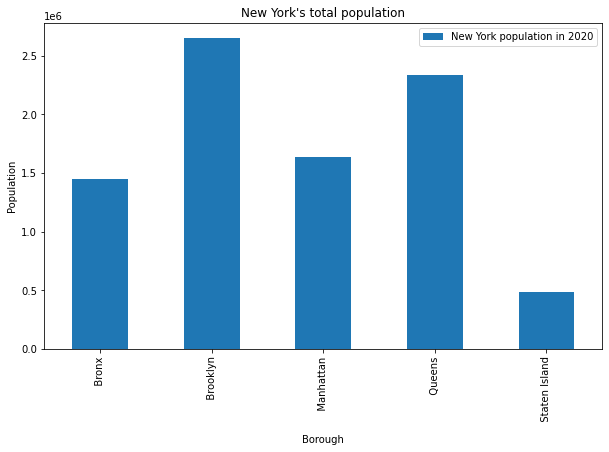

In [15]:
ny_data_total_population = df[['Borough', 'New York population in 2020']]
ny_data_total_population = ny_data_total_population.pivot_table(index= ['Borough'])

ny_data_total_population.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('New York\'s total population') # add title to the plot
plt.show()

### Plot population between 25 to 44 for each borough

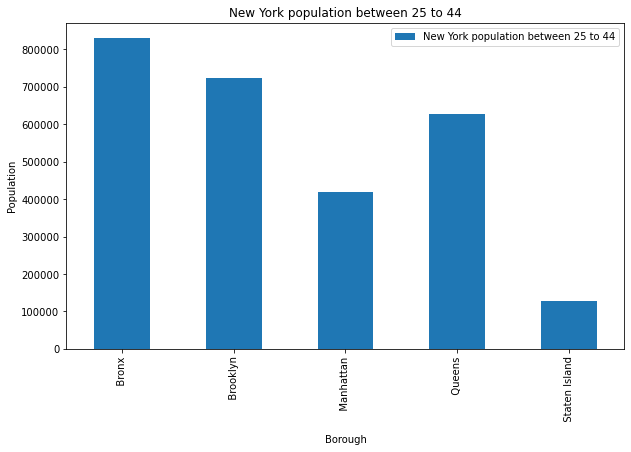

In [16]:
ny_data_population = df[['Borough', 'New York population between 25 to 44']]
ny_data_population = ny_data_population.pivot_table(index= ['Borough'])

ny_data_population.plot(kind='bar', figsize=(10, 6))
plt.xlabel('Borough') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('New York population between 25 to 44') # add title to the plot
plt.show()

### Plot Median household income and Per Capita income for each borough

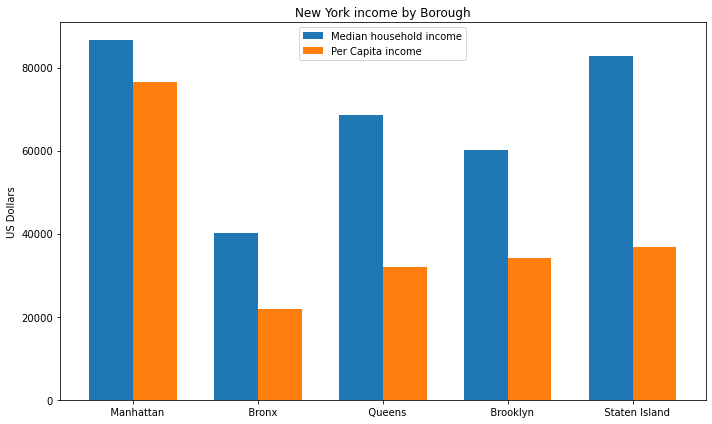

In [17]:
labels = df['Borough'].values.tolist()
median_household_income = df['Median household income (USD)']
per_capita_income = df['Per Capita income (USD)']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, median_household_income, width, label='Median household income')
rects2 = ax.bar(x + width/2, per_capita_income, width, label='Per Capita income')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('US Dollars')
ax.set_title('New York income by Borough')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

### Plot Median gross rent and Builing permits for each borough

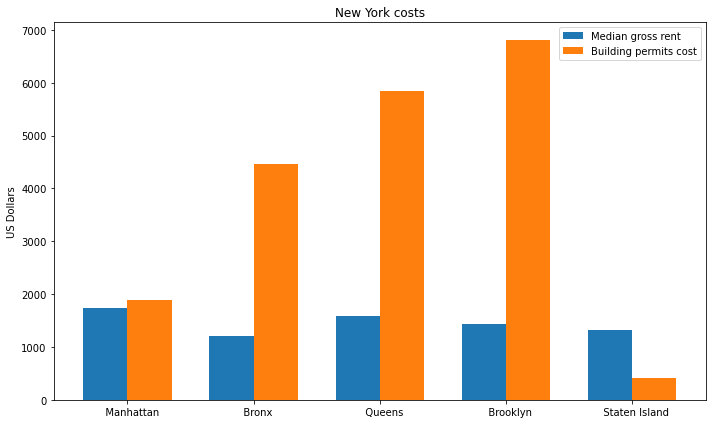

In [18]:
labels = df['Borough'].values.tolist()
median_gross_rent = df['Median gross rent (USD)']
building_permits = df['Building permits (USD)']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10,6))
rects1 = ax.bar(x - width/2, median_gross_rent, width, label='Median gross rent')
rects2 = ax.bar(x + width/2, building_permits, width, label='Building permits cost')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('US Dollars')
ax.set_title('New York costs')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
plt.show()

### Get data from Foursquare API

In [19]:
CLIENT_ID = keys.id
CLIENT_SECRET = keys.secret 
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

### Get New York Data from JSON file

In [22]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

### Create New York DataFrame

In [23]:
neighborhoods_data = newyork_data['features']

In [24]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

In [25]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

### Create Boroughs DataFrames

In [26]:
manhattan_data = neighborhoods[neighborhoods['Borough'] == 'Manhattan'].reset_index(drop=True)

In [27]:
bronx_data = neighborhoods[neighborhoods['Borough'] == 'Bronx'].reset_index(drop=True)

In [28]:
queens_data = neighborhoods[neighborhoods['Borough'] == 'Queens'].reset_index(drop=True)

In [29]:
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)

In [30]:
staten_data = neighborhoods[neighborhoods['Borough'] == 'Staten Island'].reset_index(drop=True)

### Select only the wanted categories for each neighborhood

In [31]:
subcategories = ['Mexican Restaurant', 'Paella Restaurant', 'Sushi Restaurant', 'Steakhouse', 'Café', 'Seafood Restaurant', 'Bar', 'Bistro', 
                 'Cocktail Bar', 'Gay Bar', 'Wine Bar', 'Whisky Bar', 'Jazz Club', 'Piano Bar']

### Get the Nearby Venues from each Neighborhood

In [32]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    print("Loading venues ...")
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        number_of_boroughs += 1
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    print("DONE !!!")
    return(nearby_venues)

### Get most common venues from each neighborhood

In [33]:
def return_dataframe_most_common_venues(number_top_venues, borough_grouped) :

    indicators = ['st', 'nd', 'rd']

    # create columns according to number of top venues
    columns = ['Neighborhood']
    for ind in np.arange(number_top_venues):
        try:
            columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
        except:
            columns.append('{}th Most Common Venue'.format(ind+1))

    # create a new dataframe
    neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
    neighborhoods_venues_sorted['Neighborhood'] = borough_grouped['Neighborhood']

    for ind in np.arange(borough_grouped.shape[0]):
        neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(borough_grouped.iloc[ind, :], number_top_venues)

    return neighborhoods_venues_sorted


In [34]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Create the clusters 

In [35]:
def return_clusters(number_clusters, borough_grouped, neighborhoods_venues_sorted) :

    borough_grouped_clustering = borough_grouped.drop('Neighborhood', 1)

    # run k-means clustering
    kmeans = KMeans(n_clusters=number_clusters, random_state=0).fit(borough_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    kmeans.labels_[0:10] 
    
    # add clustering labels
    neighborhoods_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)
    
    return neighborhoods_venues_sorted

## Manhattan venues

#### To allow the notebook to run faster and without errors, for each Borough the dataframe that is returned from the getNearbyVenues function is saved in a csv file to then be readed, so the maximun number of API calls is not exceeded.

In [36]:
#manhattan_venues = getNearbyVenues(names=manhattan_data['Neighborhood'],latitudes=manhattan_data['Latitude'],longitudes=manhattan_data['Longitude'])
#manhattan_venues = manhattan_venues[manhattan_venues['Venue Category'].isin(subcategories)]
#manhattan_venues.to_csv('manhattan_venues.csv', index=False)

### Read venues from Manhattan csv

In [37]:
manhattan_venues = pd.read_csv("manhattan_venues.csv")

### View Manhattan category venues

In [38]:
manhattan_venues.groupby("Venue Category").count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,54,54,54,54,54,54
Bistro,6,6,6,6,6,6
Café,83,83,83,83,83,83
Cocktail Bar,53,53,53,53,53,53
Gay Bar,1,1,1,1,1,1
Jazz Club,6,6,6,6,6,6
Mexican Restaurant,52,52,52,52,52,52
Paella Restaurant,2,2,2,2,2,2
Piano Bar,1,1,1,1,1,1


### Analyze each neighborhood 

In [39]:
# one hot encoding
manhattan_venues_categories = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_venues_categories['Neighborhood'] = manhattan_venues['Neighborhood'] 

In [40]:
manhattan_grouped = manhattan_venues_categories.groupby('Neighborhood').mean().reset_index()

### Return the most common venues for each neighborhood in Manhattan 

In [41]:
manhattan_neighborhoods_venues_sorted = return_dataframe_most_common_venues(14, manhattan_grouped)

#### In case of wanting to change the number of clusters for the Manhattan venues, run the following cell and change the number of cluster passed in the return_clusters function.

In [42]:
#manhattan_neighborhoods_venues_sorted = manhattan_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
#manhattan_merged= manhattan_merged.drop(['Cluster Labels'], axis=1)

### Create the clusters for Manhattan according to the most common venues

In [43]:
manhattan_merged = return_clusters(7, manhattan_grouped, manhattan_neighborhoods_venues_sorted)

### View clusters

In [44]:
manhattan_merged = manhattan_merged.sort_values('Cluster Labels').reset_index(drop=True)

In [45]:
manhattan_merged

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue,13th Most Common Venue,14th Most Common Venue
0,Carnegie Hill,0,Café,Bar,Cocktail Bar,Sushi Restaurant,Gay Bar,Mexican Restaurant,Wine Bar,Bistro,Jazz Club,Paella Restaurant,Piano Bar,Seafood Restaurant,Steakhouse,Whisky Bar
1,Hudson Yards,0,Café,Bar,Cocktail Bar,Steakhouse,Wine Bar,Bistro,Gay Bar,Jazz Club,Mexican Restaurant,Paella Restaurant,Piano Bar,Seafood Restaurant,Sushi Restaurant,Whisky Bar
2,Chelsea,0,Bar,Café,Cocktail Bar,Paella Restaurant,Seafood Restaurant,Sushi Restaurant,Bistro,Gay Bar,Jazz Club,Mexican Restaurant,Piano Bar,Steakhouse,Whisky Bar,Wine Bar
3,Tribeca,0,Wine Bar,Café,Bar,Steakhouse,Mexican Restaurant,Seafood Restaurant,Sushi Restaurant,Whisky Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Paella Restaurant,Piano Bar
4,Turtle Bay,0,Seafood Restaurant,Steakhouse,Sushi Restaurant,Bar,Café,Wine Bar,Cocktail Bar,Paella Restaurant,Bistro,Gay Bar,Jazz Club,Mexican Restaurant,Piano Bar,Whisky Bar
5,Upper West Side,0,Bar,Café,Wine Bar,Seafood Restaurant,Sushi Restaurant,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Paella Restaurant,Piano Bar,Steakhouse,Whisky Bar
6,Financial District,1,Cocktail Bar,Bar,Café,Mexican Restaurant,Steakhouse,Seafood Restaurant,Bistro,Gay Bar,Jazz Club,Paella Restaurant,Piano Bar,Sushi Restaurant,Whisky Bar,Wine Bar
7,West Village,1,Cocktail Bar,Seafood Restaurant,Wine Bar,Jazz Club,Bistro,Café,Piano Bar,Steakhouse,Sushi Restaurant,Bar,Gay Bar,Mexican Restaurant,Paella Restaurant,Whisky Bar
8,Clinton,1,Cocktail Bar,Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar,Bistro,Café,Gay Bar,Jazz Club,Paella Restaurant,Piano Bar,Sushi Restaurant,Whisky Bar
9,Chinatown,1,Cocktail Bar,Mexican Restaurant,Wine Bar,Bar,Bistro,Café,Gay Bar,Jazz Club,Paella Restaurant,Piano Bar,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar


## Bronx venues

In [46]:
#bronx_venues = getNearbyVenues(names=bronx_data['Neighborhood'],latitudes=bronx_data['Latitude'],longitudes=bronx_data['Longitude'])
#bronx_venues = bronx_venues[bronx_venues['Venue Category'].isin(subcategories)]
#bronx_venues.to_csv('bronx_venues.csv', index=False)

In [47]:
bronx_venues = pd.read_csv("bronx_venues.csv")

### View Bronx categories venues

In [48]:
bronx_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,15,15,15,15,15,15
Café,8,8,8,8,8,8
Mexican Restaurant,27,27,27,27,27,27
Piano Bar,1,1,1,1,1,1
Seafood Restaurant,7,7,7,7,7,7
Sushi Restaurant,2,2,2,2,2,2


### Analyze each Neighborhood

In [49]:
# one hot encoding
bronx_venues_categories = pd.get_dummies(bronx_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bronx_venues_categories['Neighborhood'] = bronx_venues['Neighborhood'] 

In [50]:
bronx_grouped = bronx_venues_categories.groupby('Neighborhood').mean().reset_index()

### Return the most common venues for each neighborhood in Bronx 

In [51]:
bronx_neighborhoods_venues_sorted = return_dataframe_most_common_venues(6, bronx_grouped)

#### In case of wanting to change the number of clusters for the Bronx venues, run the following cell and change the number of cluster passed in the return_clusters function.

In [52]:
#bronx_neighborhoods_venues_sorted = bronx_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
#bronx_merged= bronx_merged.drop(['Cluster Labels'], axis=1)

### Create the clusters for Bronx according to the most common venues

In [53]:
bronx_merged = return_clusters(10, bronx_grouped, bronx_neighborhoods_venues_sorted)

### Drop all neighborhoods that do not have any of the desire characteristics

In [54]:
bronx_merged = bronx_merged.dropna()

### View clusters

In [55]:
bronx_merged = bronx_merged.sort_values('Cluster Labels').reset_index(drop=True)

In [56]:
bronx_merged

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Allerton,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
1,Pelham Bay,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
2,Parkchester,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
3,Norwood,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
4,Melrose,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
5,Concourse Village,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
6,Longwood,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
7,Baychester,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
8,Bedford Park,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant
9,Bronxdale,0,Mexican Restaurant,Bar,Café,Piano Bar,Seafood Restaurant,Sushi Restaurant


## Queens venues

In [57]:
#queens_venues = getNearbyVenues(names=queens_data['Neighborhood'],latitudes=queens_data['Latitude'],longitudes=queens_data['Longitude'])
#queens_venues = queens_venues[queens_venues['Venue Category'].isin(subcategories)]
#queens_venues.to_csv('queens_venues.csv', index=False)

In [58]:
queens_venues = pd.read_csv("queens_venues.csv")

### View Queens categories venues

In [59]:
queens_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,43,43,43,43,43,43
Bistro,2,2,2,2,2,2
Café,27,27,27,27,27,27
Cocktail Bar,5,5,5,5,5,5
Gay Bar,1,1,1,1,1,1
Mexican Restaurant,32,32,32,32,32,32
Seafood Restaurant,17,17,17,17,17,17
Steakhouse,6,6,6,6,6,6
Sushi Restaurant,23,23,23,23,23,23


### Analyze each Neighborhood

In [60]:
# one hot encoding
queens_venues_categories = pd.get_dummies(queens_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
queens_venues_categories['Neighborhood'] = queens_venues['Neighborhood'] 

In [61]:
queens_grouped = queens_venues_categories.groupby('Neighborhood').mean().reset_index()

### Return the most common venues for each neighborhood in Queens 

In [62]:
queens_neighborhoods_venues_sorted = return_dataframe_most_common_venues(10, queens_grouped)

#### In case of wanting to change the number of clusters for the Queens venues, run the following cell and change the number of cluster passed in the return_clusters function.

In [63]:
#queens_neighborhoods_venues_sorted = manhattan_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
#queens_merged= manhattan_merged.drop(['Cluster Labels'], axis=1)

### Create the clusters for Queens according to the most common venues

In [64]:
queens_merged = return_clusters(14, queens_grouped, queens_neighborhoods_venues_sorted)

### Drop all neighborhoods that do not have any of the desire characteristics

In [65]:
queens_merged = queens_merged.dropna()

### View clusters

In [66]:
queens_merged = queens_merged.sort_values('Cluster Labels').reset_index(drop=True)

In [67]:
queens_merged 

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Kew Gardens Hills,0,Sushi Restaurant,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar
1,Rego Park,0,Sushi Restaurant,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar
2,Oakland Gardens,0,Sushi Restaurant,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar
3,Middle Village,0,Sushi Restaurant,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar
4,Maspeth,0,Sushi Restaurant,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Wine Bar
5,South Ozone Park,1,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Wine Bar
6,Pomonok,1,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Wine Bar
7,Murray Hill,1,Bar,Bistro,Café,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Wine Bar
8,Kew Gardens,1,Bar,Café,Bistro,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Wine Bar
9,Woodside,1,Bar,Café,Bistro,Cocktail Bar,Gay Bar,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Wine Bar


## Brooklyn venues

In [68]:
#brooklyn_venues = getNearbyVenues(names=brooklyn_data['Neighborhood'],latitudes=brooklyn_data['Latitude'],longitudes=brooklyn_data['Longitude'])
#brooklyn_venues = brooklyn_venues[brooklyn_venues['Venue Category'].isin(subcategories)]
#brooklyn_venues.to_csv('brooklyn_venues.csv', index=False)

In [69]:
brooklyn_venues = pd.read_csv("brooklyn_venues.csv")

### View Brooklyn categories venues

In [70]:
brooklyn_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,78,78,78,78,78,78
Bistro,1,1,1,1,1,1
Café,45,45,45,45,45,45
Cocktail Bar,36,36,36,36,36,36
Gay Bar,1,1,1,1,1,1
Jazz Club,3,3,3,3,3,3
Mexican Restaurant,47,47,47,47,47,47
Seafood Restaurant,20,20,20,20,20,20
Steakhouse,7,7,7,7,7,7


### Analyze each Neighborhood

In [71]:
# one hot encoding
brooklyn_venues_categories = pd.get_dummies(brooklyn_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
brooklyn_venues_categories['Neighborhood'] = brooklyn_venues['Neighborhood'] 

In [72]:
brooklyn_grouped = brooklyn_venues_categories.groupby('Neighborhood').mean().reset_index()

### Return the most common venues for each neighborhood in Brooklyn 

In [73]:
brooklyn_neighborhoods_venues_sorted = return_dataframe_most_common_venues(12, brooklyn_grouped)

#### In case of wanting to change the number of clusters for the Brooklyn venues, run the following cell and change the number of cluster passed in the return_clusters function.

In [74]:
#brooklyn_neighborhoods_venues_sorted = brooklyn_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
#brooklyn_merged= brooklyn_merged.drop(['Cluster Labels'], axis=1)

### Create the clusters for Brooklyn according to the most common venues

In [75]:
brooklyn_merged = return_clusters(23, brooklyn_grouped, brooklyn_neighborhoods_venues_sorted)

### Drop all neighborhoods that do not have any of the desire characteristics

In [76]:
brooklyn_merged = brooklyn_merged.dropna()

### View clusters

In [77]:
brooklyn_merged = brooklyn_merged.sort_values('Cluster Labels').reset_index(drop=True)

In [78]:
brooklyn_merged 

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,11th Most Common Venue,12th Most Common Venue
0,Sheepshead Bay,0,Café,Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
1,Remsen Village,0,Café,Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
2,Manhattan Beach,0,Café,Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
3,Crown Heights,0,Café,Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
4,Borough Park,0,Café,Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
5,Gerritsen Beach,1,Bar,Café,Seafood Restaurant,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar,Wine Bar
6,Brooklyn Heights,1,Bar,Café,Mexican Restaurant,Sushi Restaurant,Wine Bar,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Seafood Restaurant,Steakhouse,Whisky Bar
7,Windsor Terrace,1,Bar,Café,Sushi Restaurant,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Whisky Bar,Wine Bar
8,Bay Ridge,1,Bar,Café,Sushi Restaurant,Mexican Restaurant,Seafood Restaurant,Bistro,Cocktail Bar,Gay Bar,Jazz Club,Steakhouse,Whisky Bar,Wine Bar
9,Bedford Stuyvesant,1,Bar,Café,Cocktail Bar,Wine Bar,Bistro,Gay Bar,Jazz Club,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant,Whisky Bar


## Staten Island venues

In [79]:
#staten_venues = getNearbyVenues(names=staten_data['Neighborhood'],latitudes=staten_data['Latitude'], longitudes=staten_data['Longitude'])
#staten_venues = staten_venues[staten_venues['Venue Category'].isin(subcategories)]
#staten_venues.to_csv('staten_venues.csv', index=False)

In [80]:
staten_venues = pd.read_csv("staten_venues.csv")

### View Staten Island categories venues

In [81]:
staten_venues.groupby('Venue Category').count()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude
Venue Category,,,,,,
Bar,18,18,18,18,18,18
Café,8,8,8,8,8,8
Mexican Restaurant,13,13,13,13,13,13
Seafood Restaurant,2,2,2,2,2,2
Steakhouse,1,1,1,1,1,1
Sushi Restaurant,12,12,12,12,12,12


### Analyze each Neighborhood

In [82]:
# Read a csv file
df = pd.read_csv("NY_population_by_borough.csv")

# Select the columsn of Borough,2020 population and share of ny
df = df.iloc[:, [1,16,17]] 
ny_total_population = df.iloc[0,1]
df = df.drop([0], axis=0)
df = df.reindex([3,1,4,2,5])
df = df.reset_index(drop = True)

In [83]:
# one hot encoding
staten_venues_categories = pd.get_dummies(staten_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
staten_venues_categories['Neighborhood'] = staten_venues['Neighborhood'] 

In [84]:
staten_grouped = staten_venues_categories.groupby('Neighborhood').mean().reset_index()

### Return the most common venues for each neighborhood in Staten Island 

In [85]:
staten_neighborhoods_venues_sorted = return_dataframe_most_common_venues(6, staten_grouped)

#### In case of wanting to change the number of clusters for the Staten Island venues, run the following cell and change the number of cluster passed in the return_clusters function.

In [86]:
#staten_neighborhoods_venues_sorted = staten_neighborhoods_venues_sorted.drop(['Cluster Labels'], axis=1)
#staten_merged= staten_merged.drop(['Cluster Labels'], axis=1)

### Create the clusters for Staten Island according to the most common venues

In [87]:
staten_merged = return_clusters(7, staten_grouped, staten_neighborhoods_venues_sorted)

### Drop all neighborhoods that do not have any of the desire characteristics

In [88]:
staten_merged = staten_merged.dropna()

### View the clusters

In [89]:
staten_merged = staten_merged.sort_values('Cluster Labels').reset_index(drop=True)

In [90]:
staten_merged

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,Woodrow,0,Mexican Restaurant,Sushi Restaurant,Bar,Café,Seafood Restaurant,Steakhouse
1,Tompkinsville,0,Café,Mexican Restaurant,Seafood Restaurant,Bar,Steakhouse,Sushi Restaurant
2,New Dorp,0,Mexican Restaurant,Sushi Restaurant,Bar,Café,Seafood Restaurant,Steakhouse
3,West Brighton,1,Bar,Café,Mexican Restaurant,Seafood Restaurant,Steakhouse,Sushi Restaurant
4,Castleton Corners,1,Bar,Mexican Restaurant,Café,Seafood Restaurant,Steakhouse,Sushi Restaurant
5,Dongan Hills,1,Bar,Sushi Restaurant,Café,Mexican Restaurant,Seafood Restaurant,Steakhouse
6,Stapleton,1,Bar,Mexican Restaurant,Seafood Restaurant,Café,Steakhouse,Sushi Restaurant
7,Grant City,1,Bar,Mexican Restaurant,Café,Seafood Restaurant,Steakhouse,Sushi Restaurant
8,Great Kills,1,Bar,Mexican Restaurant,Café,Seafood Restaurant,Steakhouse,Sushi Restaurant
9,Rosebank,1,Bar,Mexican Restaurant,Café,Seafood Restaurant,Steakhouse,Sushi Restaurant
